In [1]:
from typing import List, Dict, Any
import pandas as pd
from src.utils.methods import ConformanceMetrics



conformance_metrics: List[tuple[int, ConformanceMetrics | None, tuple[str, str]]] = []


DATA_PATH: str = "/Users/christianimenkamp/Documents/Data-Repository/"
RECURRING_DRIFT_LOG_NAME: str = "Merged/recurring_drift_short[bpi-c-2012,bpi-c-2013].feather"

BPI_C_2012: pd.DataFrame = pd.read_feather(DATA_PATH + "Community/bpi-c-2012/data.feather")
BPI_C_2013: pd.DataFrame = pd.read_feather(DATA_PATH + "Community/bpi-c-2013/data.feather")
BPI_C_2015: pd.DataFrame = pd.read_feather(DATA_PATH + "Community/bpi-c-2015/data.feather")

RECURRING_DRIFT_LOG: pd.DataFrame = pd.read_feather(DATA_PATH + RECURRING_DRIFT_LOG_NAME)

bpi_c_2012_names = set(BPI_C_2012['concept:name'].unique())
bpi_c_2013_names = set(BPI_C_2013['concept:name'].unique())
bpi_c_2015_names = set(BPI_C_2015['concept:name'].unique())

def determine_log_source(row: pd.Series) -> str:
    concept_name: str = row['concept:name']
    if concept_name in bpi_c_2012_names:
        return 'BPI_C_2012'
    elif concept_name in bpi_c_2013_names:
        return 'BPI_C_2013'
    elif concept_name in bpi_c_2015_names:
        return 'BPI_C_2015'
    else:
        return 'Unknown'

def on_full_completeness(window: List[Dict[str, Any]], window_counter: int) -> None:
    e_1 = window[0]["concept:name"]
    e_2 = window[-1]["concept:name"]
    conformance_metrics.append((len(window), None, (e_1, e_2)))

RECURRING_DRIFT_LOG['META:LOG_SOURCE'] = RECURRING_DRIFT_LOG.apply(determine_log_source, axis=1)
START_AT, STOP_AT = (0, len(RECURRING_DRIFT_LOG)-1)
COMPLETENESS_THRESHOLD: float = 0.6

In [2]:
from src.estimator_accumulative import WindowEstimator

window = WindowEstimator(
    on_full_completeness=on_full_completeness
)


for i, row in RECURRING_DRIFT_LOG.iterrows():
    window.add_event(row.to_dict())

    if START_AT < i <= STOP_AT:
        window.get_metrics(DEBUG=False)

    if i == STOP_AT + 1:
        break


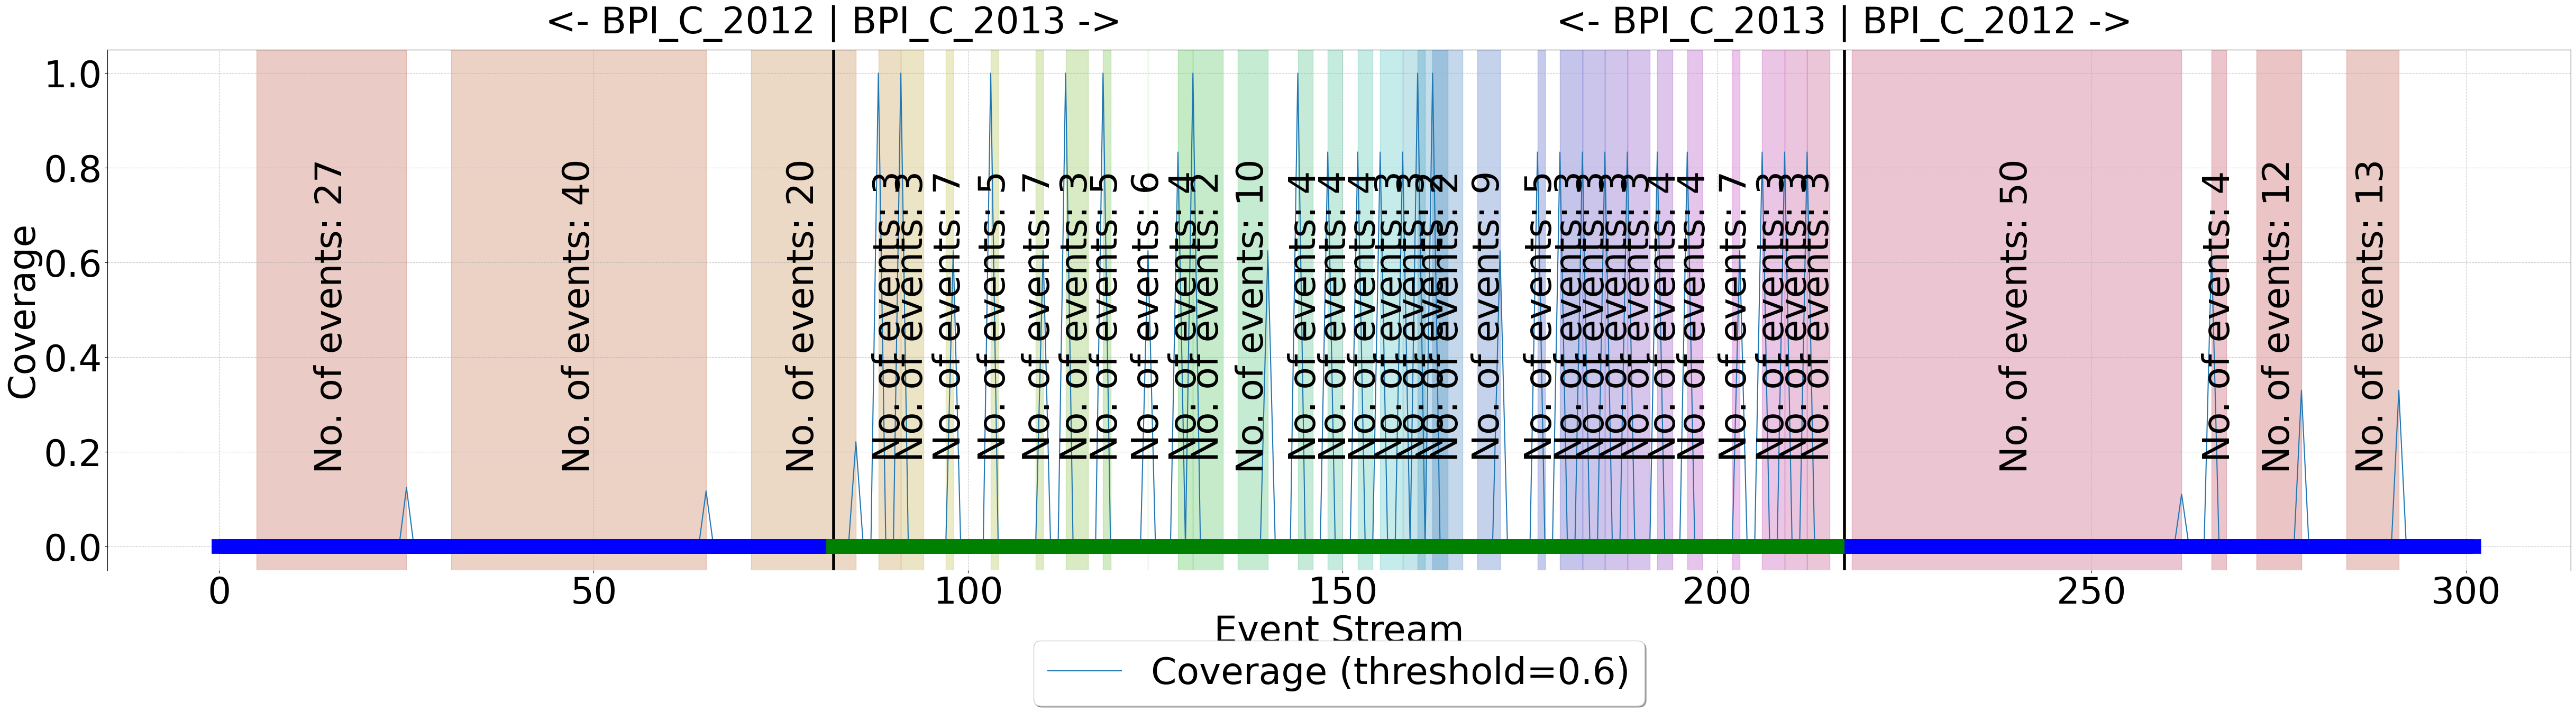

In [3]:
from src.utils.methods import ConformanceMetrics, find_non_zero_ranges
from src.utils.plotter import Plotter
from typing import List

x_axis_range: List[int] = list(range(START_AT, STOP_AT))
plotter = Plotter(x_axis_range)

full_completeness: list[int] = [y[1] for y in window.completeness_cache]

plotter.add_subplot(
    [
        (f"Coverage (threshold={COMPLETENESS_THRESHOLD})", full_completeness),
    ],
    y_label="Coverage",
)


for i, block in enumerate(find_non_zero_ranges(full_completeness)):
    try:
        block_fit: tuple[int, ConformanceMetrics, tuple[str, str]] = conformance_metrics[i]
        plotter.shade_regions(
            block[0],
            block[1],
            alpha=0.3,
            text=f"No. of events: {block_fit[0]} {''}",
            position="middle",
            orientation="vertical",
        )
    except IndexError:
        pass


for i, row in RECURRING_DRIFT_LOG.iterrows():
    el_src: str = row["META:LOG_SOURCE"]
    if el_src == "BPI_C_2012":
        plotter.mark_point_on_x_axis(i, "blue")
    elif el_src == "BPI_C_2013":
        plotter.mark_point_on_x_axis(i, "green")
    elif el_src == "BPI_C_2015":
        plotter.mark_point_on_x_axis(i, "blue")
    else:
        plotter.plot_event(i, "black")

thn: float = 4.0
plotter.draw_vertical_line(82, color="black", thickness=thn, label="<- BPI_C_2012 | BPI_C_2013 ->")
plotter.draw_vertical_line(217, color="black", thickness=thn, label="<- BPI_C_2013 | BPI_C_2012 ->")

# plotter.add_subplot(
#     [
#         (f"Threshold", window.threshold_cache),
#     ],
#     include_extras=False,
#     y_label="Threshold",
# )

plotter.plot(50, 15, x_label="Event Stream", font_size=50)

